<a href="https://colab.research.google.com/github/weswest/MSDS460/blob/master/ExampleModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Your Functions

In [1]:
import os
import datetime
import json

import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import random

random_seed = 458
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

import csv
import pickle

%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 


# Point you colab environment to the appropriate folder within your Google Drive space

This is a life-saver.  Yeah, you can just search for whatever, but why pollute your top level google drive with a bunch of stuff?

Note: the "folder" callout is used later when saving down models.

In [2]:
folder = 'train'

from google.colab import drive
drive.mount('/content/drive')
try:
  os.chdir("drive/My Drive/MSDS/458/A2_CIFAR")
except:
  pass

Mounted at /content/drive


# Code pulled from the TA's github to get started

This block does all of the data preprocessing from the TA codebase.  There's more here, but this is an example file not a full-blown assignment.  Do your homework.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Functions

I've got a full-time job, a kid, and a life outside of work and school.  I don't have the luxury of sitting down and working on only my homework in eight-hour chunks.  I therefore often need to write code, hit "run", and come back later to see how it performed.

The one downside is that there are a bunch of aspects of model development that most easily live "in state".  Keras has the ModelCheckpoint callback that will save down the structure of the model, but there are other aspects of training that I'd love to have available, including:

* Per-Epoch training and validation loss and accuracy
* Number of epochs needed to train the model
* Total time spent training the model.

The functions below help out with that.  *italicized text*

## Build Model Function

There are two functions defined in here: the "fit model" function and the "build or load model" function.

### Fit Model

The fit model function takes as inputs a keras model's structure and a text reference name.  It then compiles and fits the model based on a user-defined template.

The function also captures the start / end time of the model building process.  It then saves down:
* The resultant model .h5 file and the model's training history file into a model-specific folder
* The time to process in a top-level locally saved dictionary of model training times

# Build or Load Model

This function is essentially a controller function that checks whether the model we want to build already exists.  If it exists, then it loads the model; if it doesn't exist then it runs the "fit model" function and builds it for you.

What this means is that, in practice, you can define a line of, e.g.,:

model = build_or_load_model(details)

And know that if you need to restart your Colab session that already-existing models will be loaded and new models will be rebuilt.

In [5]:
def fit_model(modelName_keras, modelName_str, 
              x_train = x_train_norm, y_train = y_train_split, 
              x_val = x_valid_norm, y_val = y_valid_split):
  
  model_filename = folder + modelName_str + '/' + modelName_str + '.h5'
  start = datetime.datetime.now()
  modelName_keras.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
  history = modelName_keras.fit(
    x_train
    ,y_train
    ,epochs = 200
    ,batch_size = 64
    ,validation_data=(x_valid_norm, y_valid_split)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint(model_filename,save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)] 
    )
  end = datetime.datetime.now()
  time_diff = end - start
  print('Build time: ', time_diff)
  writeTime(modelName_str, time_diff.total_seconds())
  hist_filename = folder + modelName_str + '/' + modelName_str + 'hist'
  with open(hist_filename, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

def build_or_load_model(modelName_keras, modelName_str, 
                        force_rebuild = False, 
                        x_train = x_train_norm, y_train = y_train_split, 
                        x_val = x_valid_norm, y_val = y_valid_split):

  model_filename = folder + modelName_str + '/' + modelName_str + '.h5'
  if force_rebuild:
    fit_model(modelName_keras, modelName_str, x_train, y_train, x_val, y_val)
  
  if os.path.exists(model_filename):
    print('Model already exists!  Loading and saving you some time!')
  else:
    print('Building the model!')
    fit_model(modelName_keras, modelName_str, x_train, y_train, x_val, y_val)
  model = keras.models.load_model(model_filename)
  return model

### Time-Save Function

The "writeTime" function references a user-defined file name where model training times will be saved.  This function is used in the above model-building function to write training times into this locally-saved file

The printModelTime function loads the dictionary and prints out all of the model times.

In [6]:
## These functions create a saved-down dictionary of how long it took each model to execute

def writeTime(modelName_str, modelTime_value):
  modelTime_file = 'modelTime.json'

  try:
    with open(modelTime_file) as json_file:
      modelTime_dict = json.load(json_file)

  except:
    modelTime_dict = {}

  modelTime_dict[modelName_str] = modelTime_value

  with open(modelTime_file, "w") as outfile:
    json.dump(modelTime_dict, outfile)

def printModelTime():
  with open('modelTime.json') as json_file:
    times = json.load(json_file)
  
  for key, value in times.items():
    print(key, '\t:\t', value)

## Plot_Acc_Loss

One of the nice things about keras is that simple commands can spit out the accuracy and loss graphs from the training environment.  These functions don't work well when you save-and-then-load your history data.

So I coded my own.  Shrug.

In [7]:
# plot acc loss takes in a history dict and spits out the train/validation accuracy and loss graphs
# Note: the way the code is structured, saving the history file down and then loading it, deletes the "history.history" item

def plot_acc_loss(history_file, model_name_str = 'No Name Given'):
  loss_train = history_file['loss']
  loss_val = history_file['val_loss']
  acc_train = history_file['accuracy']
  acc_val = history_file['val_accuracy']
  epochs = len(loss_train)
  epochs_x = list(range(1,epochs+1))

  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(15,6)
  ax1.set_title(model_name_str + ' modeled losses')
  ax1.plot(epochs_x, loss_train, label = 'Training Loss')
  ax1.plot(epochs_x, loss_val, label = 'Validation Loss')
  ax1.legend()

  ax2.set_title(model_name_str + ' modeled accuracy')
  ax2.plot(epochs_x, acc_train, label = 'Training Acc')
  ax2.plot(epochs_x, acc_val, label = 'Validation Acc')
  ax2.legend()
  
  plt.show()

#plot_acc_loss(historyE1, model_filename)

# Actually Building the Model

The code below is a simplified example of what I write when I create a new model.

The first bundle of code figures out if the target folder exists, and if not then it creates the folder.  I should probably shove this into the build_or_load function.  Oh well.

The second bundle is where you build out the model structure.  Do whatever you want here.

And then you get the model = build_or_load_model(details).  This is what triggers a build if the model doesn't exist and a load if it does.

In [8]:
model_filename = 'model_example'
model_foldername = folder + model_filename
if os.path.exists(model_foldername) == False:
  os.makedirs(model_foldername)
  
model_example = Sequential()
model_example.add(layers.Flatten(input_shape=(32, 32, 3)))
model_example.add(layers.Dense(units = 384, activation = tf.nn.relu))
model_example.add(layers.Dense(name = 'output_layer', units=10, activation = tf.nn.softmax))

model_example.summary()
#keras.utils.plot_model(model_example, model_foldername + '/' + model_filename + '.png', show_shapes=True) 

model = build_or_load_model (model_example, model_filename)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________
Building the model!
Epoch 1/200
704/704 [==============================] - 9s 11ms/step - loss: 1.9224 - accuracy: 0.3249 - val_loss: 1.7956 - val_accuracy: 0.3424
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.7129 - accuracy: 0.3899 - val_loss: 1.7178 - val_accuracy: 0.3798
Ep

In [9]:
# And now in future iterations, if you need to load the model at some later date, 
# just call the same command again and...

model = build_or_load_model (model_example, model_filename)

Model already exists!  Loading and saving you some time!


## Call Model Training Time

Embedded in the "build model" code is a series of commands that records the amount of time it takes the model to be trained and then saves it into a local json file.

The printModelTime function loads the json file and prints out the models and number of seconds spent training each model.

Note: the approach used is approximate, from a timing perspective.  There are more official ways of doing this using customized keras callbacks, but this approach works well enough, in my opinion.

In [10]:
printModelTime()

modelE1 	:	 173.164711
modelE2 	:	 191.590793
modelE3 	:	 3979.453872
modelE4 	:	 5624.836163
modelE5 	:	 213.04032
modelE6 	:	 311.452065
modelE7 	:	 5411.720533
model_example 	:	 167.429528


# And then do other stuff to evaluate the model

One of the advantages here is that you can genericize your model evaluations by only referencing "model", since the "model" pointer gets loaded with the specific model being evaluated in the build_or_load stage.

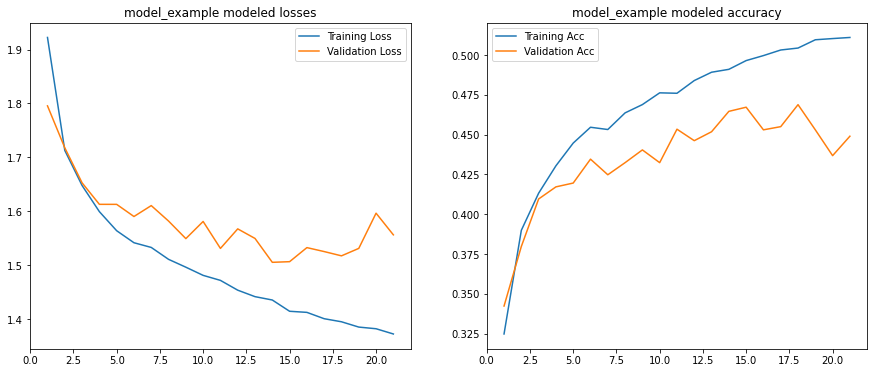

In [11]:
history = pickle.load(open(model_foldername + '/' + model_filename + 'hist', "rb"))
plot_acc_loss(history, model_filename)